## Comparing one group to a known mean (unknown population variance)

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from ministats import nicebins
from ministats import plot_pdf
from ministats.utils import savefigure


In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]
# red = sns.color_palette("tab10")[3]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

In [5]:
#######################################################
from ministats import gen_boot_dist
from ministats import tailvalues

def bootstrap_test_mean(sample, mu0, B=10000):
    """
    Compute the p-value of the observed `mean(sample)`
    under H0 with mean `mu0`. Model the variability of
    the distribution using bootstrap estimation.
    """
    # 1. Compute the observed value of the mean
    obsmean = np.mean(sample)

    # 2. Get sampling distribution of the mean under H0
    #    by "shifting" the sample so its mean is `mu0`
    sample_H0 = np.array(sample) - obsmean + mu0
    bmeans = gen_boot_dist(sample_H0, np.mean, B=B)

    # 3. Compute the p-value
    tails = tailvalues(bmeans, obsmean)
    pvalue = len(tails) / len(bmeans)

    # sns.histplot(bmeans, bins=100)
    # sns.histplot(tails, bins=100, color="r")
    return bmeans, pvalue

### Example 1 revisited

#### Mean test on batch 01

In [6]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
ksample01 = kombucha[kombucha["batch"]==1]["volume"]
bootstrap_test_mean(ksample01, mu0=1000)[1]

0.5575

Correctly accepts this as a regular batch.

In [7]:
# sns.kdeplot(ksample01)
# ksample01.describe()

#### Mean test on batch 04

In [8]:
ksample04 = kombucha[kombucha["batch"]==4]["volume"]
bootstrap_test_mean(ksample04, mu0=1000)[1]

0.0025

Correctly rejects this as an irregular batch.

In [9]:
# np.std(ksample04, ddof=1) / np.sqrt( len(ksample04) ) 

In [10]:
# sns.kdeplot(ksample04)
# ksample04.describe()

#### Mean test on batch 05 (estimated variance)

In [11]:
ksample05 = kombucha[kombucha["batch"]==5]["volume"]
bootstrap_test_mean(ksample05, mu0=1000)[1]

0.0148

Correctly rejects this as an irregular batch.

count      40.000000
mean     1002.534750
std         6.553409
min       992.090000
25%       998.515000
50%      1002.060000
75%      1004.870000
max      1027.190000
Name: volume, dtype: float64

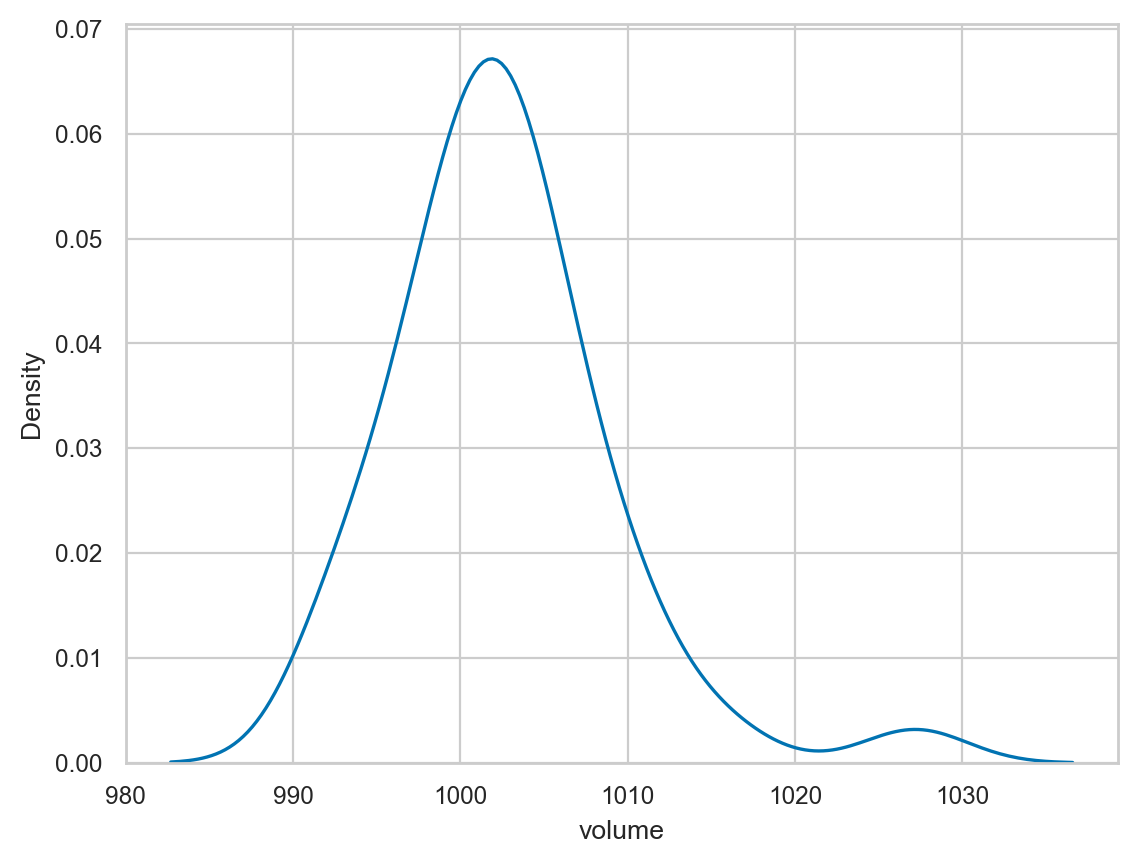

In [12]:
sns.kdeplot(ksample05)
ksample05.describe()

## Comparing with the simulation test assuming K ~ norm(1000,10)

In [13]:
from ministats import simulation_test_mean

muK = 1000
sigmaK = 10

In [14]:
simulation_test_mean(ksample01, mu0=muK, sigma0=sigmaK)

0.5729

In [15]:
simulation_test_mean(ksample04, mu0=muK, sigma0=sigmaK)

0.0139

In [16]:
simulation_test_mean(ksample05, mu0=muK, sigma0=sigmaK)

0.107

Incorrectly accepts this as a regular batch,
because it assumes $\sigma_K = 10$,
when in fact the variability is much smaller and should have rejected.

mean(ksample05) = 1002.53475
std(ksample05) = 6.553408972944293
pvalue = 0.0137


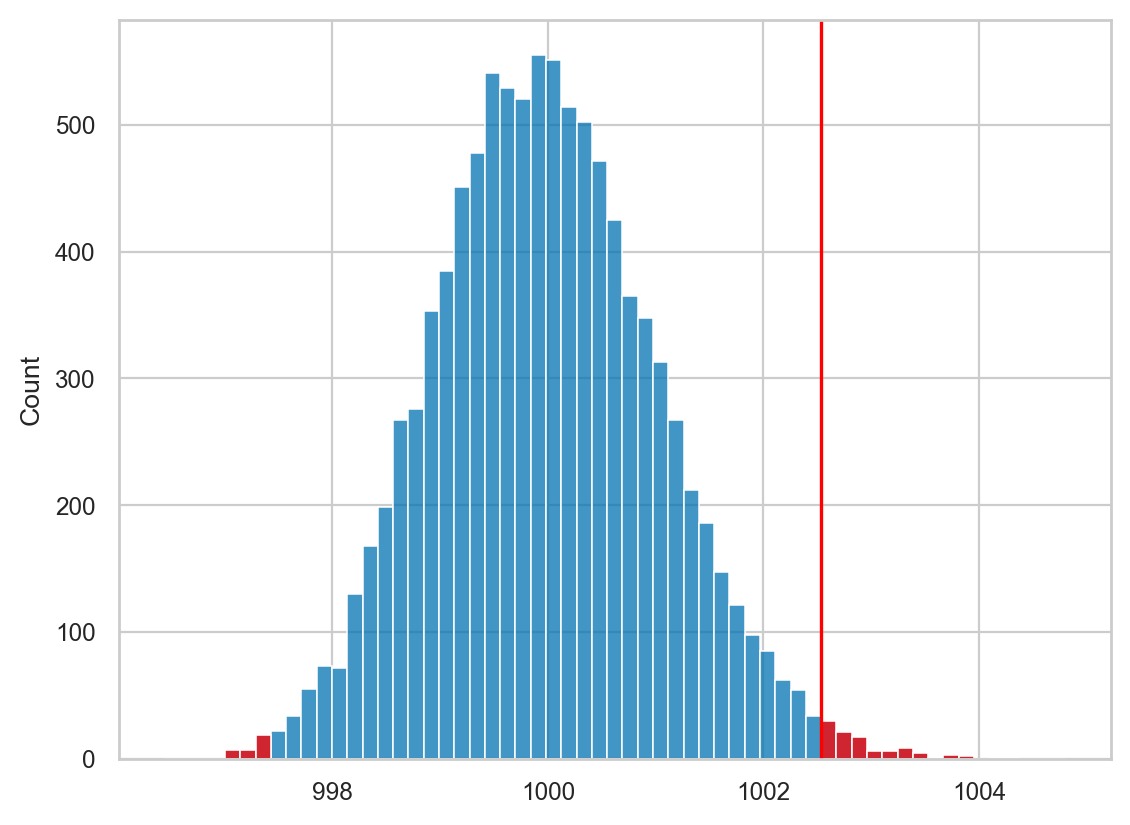

In [17]:
# ALT. fully deailed analysis

print("mean(ksample05) =", np.mean(ksample05))
print("std(ksample05) =", np.std(ksample05, ddof=1))

# bootstrap_test_mean(ksample05, mu0=1000)[1]
kbars_boot, pvalue = bootstrap_test_mean(ksample05, mu0=1000)
print("pvalue =", pvalue)

obsmean05 = np.mean(ksample05)
bins = nicebins(kbars_boot, obsmean05)
sns.histplot(kbars_boot, bins=bins)
# plot red line for the observed statistic
plt.axvline(obsmean05, color="red")

# plot the values that are equal or more extreme in red
tails = tailvalues(kbars_boot, obsmean05)
sns.histplot(tails, bins=bins, color="red");